In [4]:
import numpy as np
import pymc3 as pm
from pyei.two_by_two import TwoByTwoEI
from pyei.goodmans_er import GoodmansER, GoodmansERBayes
from pyei.data import get_data
from pyei.plot_utils import tomography_plot

In [5]:
%load_ext autoreload
%autoreload 2

# Demo of 2x2 models and plotting using Santa Clara data

We show examples of using and examining models available in `pyei` using a sample data set:

In [6]:
data = get_data("santaClara.csv")
X = np.array(data["pct_e_asian_vote"])
T = np.array(data["pct_for_hardy2"])
N = np.array(data["total2"])
demographic_group_name = "e_asian"
candidate_name="Hardy"
precinct_names = data['precinct']
data.head()

,precinct,total_turnout,total2,pct_for_hardy2,pct_for_kolstad2,pct_for_nadeem2,total5,pct_for_caserta5,pct_not_caserta5,pct_for_lacoursiere5,...,pct_for_park5,pct_not_park5,pct_asian_vote,pct_asian_pop,pct_ind_vote,pct_ind_pop,pct_e_asian_vote,pct_e_asian_pop,pct_non_asian_vote,pct_non_asian_pop
0,4201,712,658,0.246201,0.431611,0.322188,642,0.447040,0.552960,0.305296,...,0.247664,0.752336,0.054775,0.117369,0.008427,0.028632,0.046348,0.088736,0.945225,0.882631
1,4208,400,380,0.328947,0.431579,0.239474,379,0.456464,0.543536,0.192612,...,0.350923,0.649077,0.197500,0.214389,0.060000,0.075990,0.137500,0.138399,0.802500,0.785611
2,4211,609,549,0.251366,0.384335,0.364299,542,0.492620,0.507380,0.250922,...,0.256458,0.743542,0.123153,0.202214,0.042693,0.046066,0.080460,0.156147,0.876847,0.797786
3,4215,623,573,0.258290,0.371728,0.369982,558,0.431900,0.568100,0.344086,...,0.224014,0.775986,0.109149,0.162014,0.032103,0.040379,0.077047,0.121635,0.890851,0.837986
4,4217,399,359,0.281337,0.406685,0.311978,355,0.425352,0.574648,0.326761,...,0.247887,0.752113,0.142857,0.254478,0.027569,0.063620,0.115288,0.190859,0.857143,0.745522


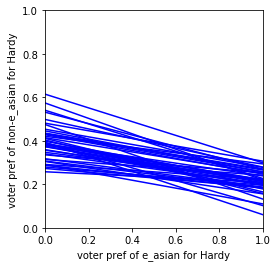

In [7]:
tomography_plot(X,T, demographic_group_name, candidate_name)

## Fitting a modified model from King 1999

This model uses different priors than from King '99: Pareto and uniform hyperparameters are used to perform partial pooling over beta distributions for the groups. The likelihood is the same (binomial) distribution. See, for example [Hierarchical Partial Pooling for Repeated Binary Trials](https://mc-stan.org/rstanarm/articles/pooling.html) for details of this prior structure.

In [5]:
ei = TwoByTwoEI(model_name="king99_pareto_modification", pareto_scale=8, pareto_shape=2)
ei.fit(X, T, N, demographic_group_name=demographic_group_name, candidate_name=candidate_name, precinct_names=precinct_names)
print(ei.summary())

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b_2, b_1, kappa_2, phi_2, kappa_1, phi_1]


Sampling 4 chains for 1_500 tune and 1_000 draw iterations (6_000 + 4_000 draws total) took 48 seconds.
There were 13 divergences after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The estimated number of effective samples is smaller than 200 for some parameters.


Model: king99_pareto_modification
        Computed from the raw b_i samples by multiplying by population and then getting
        the proportion of the total pop (total pop=summed across all districts):
        The posterior mean for the district-level voting preference of
        e_asian for Hardy is
        0.801
        The posterior mean for the district-level voting preference of
        non-e_asian for Hardy is
        0.246
        95% Bayesian credible interval for district-level voting preference of
        e_asian for Hardy is
        [0.6085915  0.94450912]
        95% Bayesian credible interval for district-level voting preference of
        non-e_asian for Hardy is
        [0.22028548 0.27729012]
        


### Plotting features for this and any model involving posterior samples:

(<matplotlib.axes._subplots.AxesSubplot at 0x7fbd7898d700>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fbd90b8c3a0>)

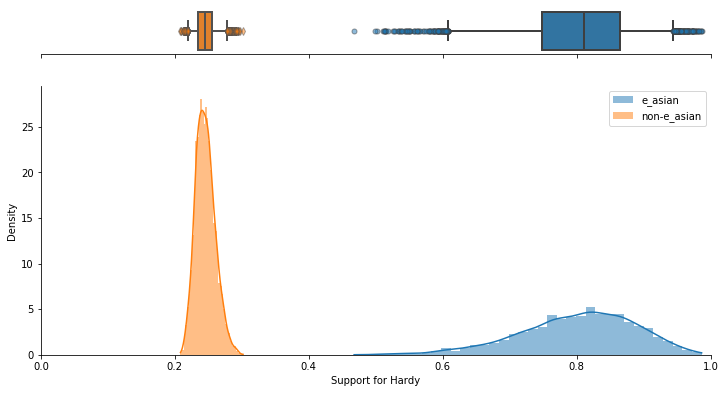

In [6]:
ei.plot()

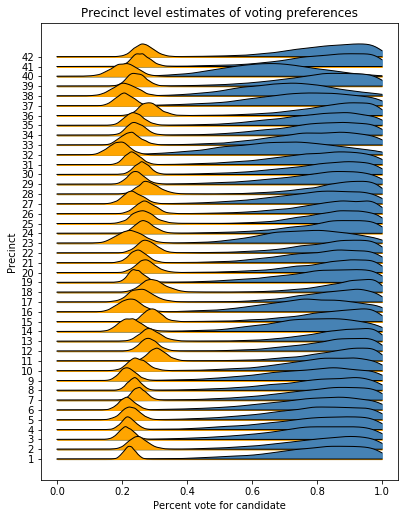

In [7]:
ei.precinct_level_plot()

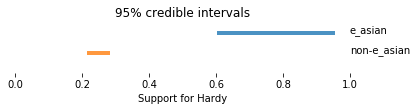

In [11]:
ei.plot_intervals()

(<matplotlib.axes._subplots.AxesSubplot at 0x7fbe6953d850>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fbe69869370>)

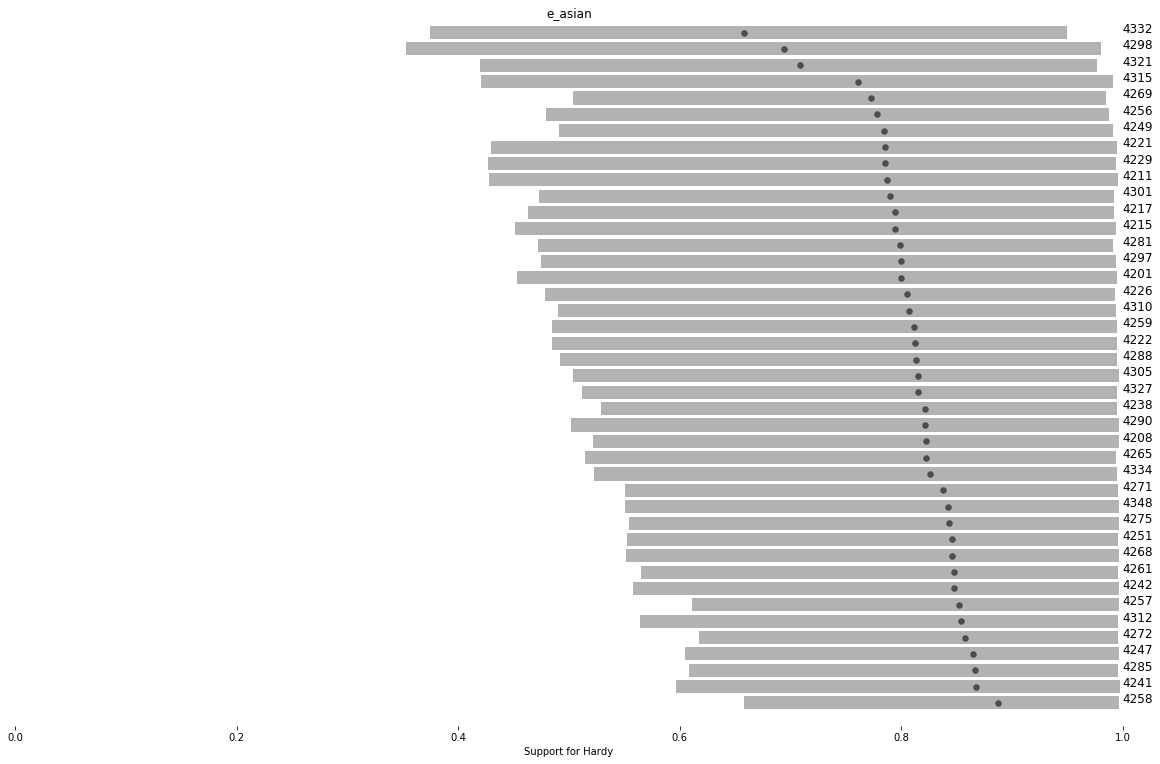

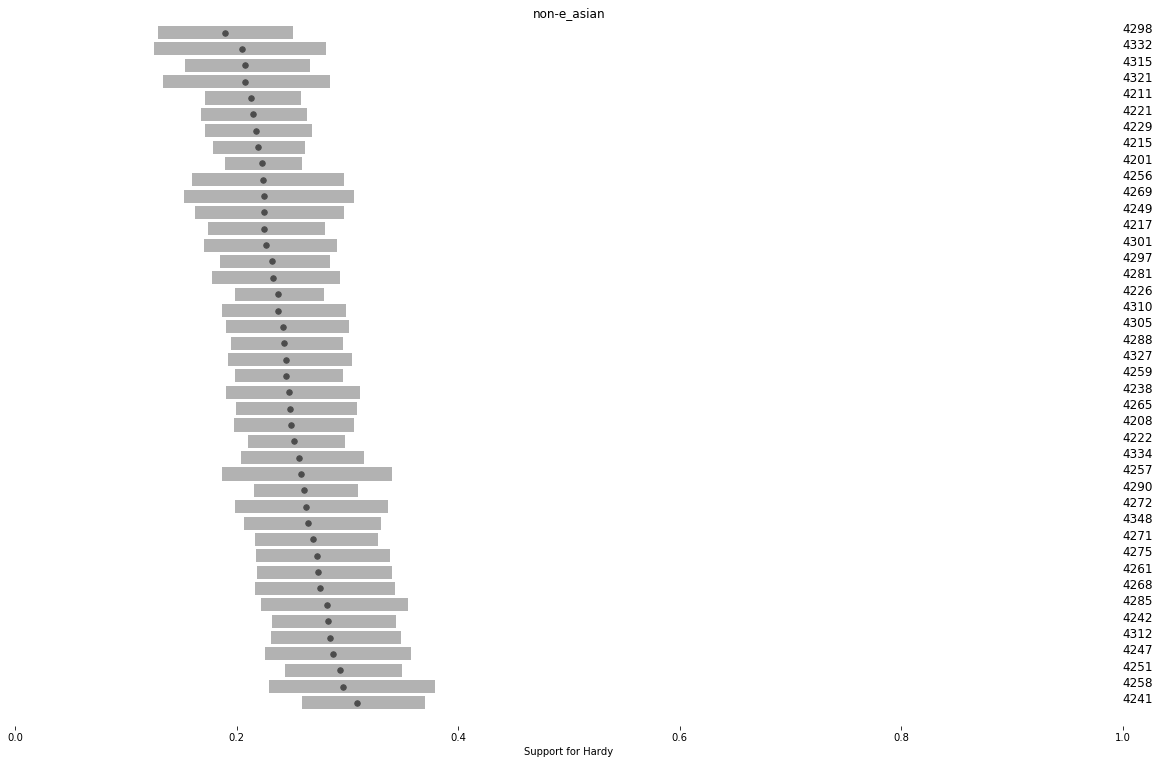

In [12]:
ei.plot_intervals_by_precinct()

## Summary features

In [13]:
print(ei.summary())

Model: king99_pareto_modification
        Computed from the raw b_i samples by multiplying by population and then getting
        the proportion of the total pop (total pop=summed across all districts):
        The posterior mean for the district-level voting preference of
        e_asian for Hardy is
        0.809
        The posterior mean for the district-level voting preference of
        non-e_asian for Hardy is
        0.244
        95% Bayesian credible interval for district-level voting preference of
        e_asian for Hardy is
        [0.60905922 0.94882981]
        95% Bayesian credible interval for district-level voting preference of
        non-e_asian for Hardy is
        [0.21974278 0.27746662]
        


### Posterior mean for district-wide voting preferences (mean of [precinct samples weighted by population]):

In [14]:
posterior_mean_voting_prefs =ei.posterior_mean_voting_prefs
print(demographic_group_name, " support for ", candidate_name, posterior_mean_voting_prefs[0])
print("non-",demographic_group_name, " support for ", candidate_name, posterior_mean_voting_prefs[1])


e_asian  support for  Hardy 0.8087581349039399
non- e_asian  support for  Hardy 0.24438023734758788


### 95% credible intervals

In [15]:
credible_interval_95_mean_voting_prefs = ei.credible_interval_95_mean_voting_prefs
print(demographic_group_name, " support for ", candidate_name, credible_interval_95_mean_voting_prefs[0])
print("non-",demographic_group_name, " support for ", candidate_name, credible_interval_95_mean_voting_prefs[1])


e_asian  support for  Hardy [0.60905922 0.94882981]
non- e_asian  support for  Hardy [0.21974278 0.27746662]


### Precinct-level means and credible intervals

In [16]:
precinct_posterior_means_gp1, precinct_posterior_means_gp2, precinct_credible_intervals_gp1, precinct_credible_intervals_gp2 = ei.precinct_level_estimates()
print(precinct_posterior_means_gp1)

[0.80026682 0.82194459 0.7867972  0.79479441 0.79404421 0.78533239
 0.81202019 0.80542798 0.78579355 0.82112408 0.86761312 0.84797392
 0.86507852 0.7848193  0.8455257  0.77770492 0.85182224 0.88761477
 0.81176258 0.8474908  0.82214109 0.84574036 0.77254973 0.83733587
 0.85734029 0.84326286 0.79852978 0.86636574 0.81352852 0.82166656
 0.80023496 0.69429293 0.78953129 0.81515021 0.80713102 0.8538319
 0.76127895 0.70899816 0.81560257 0.65785749 0.82631632 0.84214262]


## Accessing samples

Samples from the posterior distribution of district-wide voter preferences (calculated by weighting each set of precinct-level samples by the population and summing):

In [17]:
sampled_voting_prefs = ei.sampled_voting_prefs # ei.sampled_voting_prefs is samples of district-level voter preference: list of length 2
sampled_voting_prefs[0] #samples of district-wide support of specified group for specified candidate
sampled_voting_prefs[1] #samples of district-wide support of (complement of specified group) for specified candidate
sampled_voting_prefs[0].mean() #posterior mean
sampled_voting_prefs[1].mean() #posterior mean

0.24438023734758788

Precinct level samples of voting preferences:

In [18]:
precinct_num_of_interest = 5
ei.sim_trace["b_1"].shape # num_samples x num_precincts
print("calculate posterior mean for voter preference of ", demographic_group_name, " for ", candidate_name," in precinct ",precinct_num_of_interest )
ei.sim_trace["b_1"][:, precinct_num_of_interest].mean() 

calculate posterior mean for voter preference of  e_asian  for  Hardy  in precinct  5


0.7853323892027567

Posterior samples for hyperparameters are also accessible.

In [19]:
ei.sim_trace["kappa_1"].shape 

(4000,)

## Accessing and visualizing the pymc the model

In [1]:
model = ei.sim_model
pm.model_to_graphviz(model)

NameError: name 'ei' is not defined

## Fitting the model from King 1999

This is a faithful representation of the model from King '99: all of the hyperparameters are exponentially distributed with a fixed lambda value. 

In [21]:
ei = TwoByTwoEI(
    "king99", lmbda=0.1
)  # king uses 0.5, but smaller lambdas seem more stable
ei.fit(X, T, N, demographic_group_name="e asian", candidate_name="Hardy")
print(ei.summary())

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b_2, b_1, d_2, c_2, d_1, c_1]


Sampling 4 chains for 1_500 tune and 1_000 draw iterations (6_000 + 4_000 draws total) took 90 seconds.
There were 16 divergences after tuning. Increase `target_accept` or reparameterize.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
There were 41 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.


Model: king99
        Computed from the raw b_i samples by multiplying by population and then getting
        the proportion of the total pop (total pop=summed across all districts):
        The posterior mean for the district-level voting preference of
        e asian for Hardy is
        0.836
        The posterior mean for the district-level voting preference of
        non-e asian for Hardy is
        0.240
        95% Bayesian credible interval for district-level voting preference of
        e asian for Hardy is
        [0.6119189  0.97661763]
        95% Bayesian credible interval for district-level voting preference of
        non-e asian for Hardy is
        [0.21422917 0.2784871 ]
        


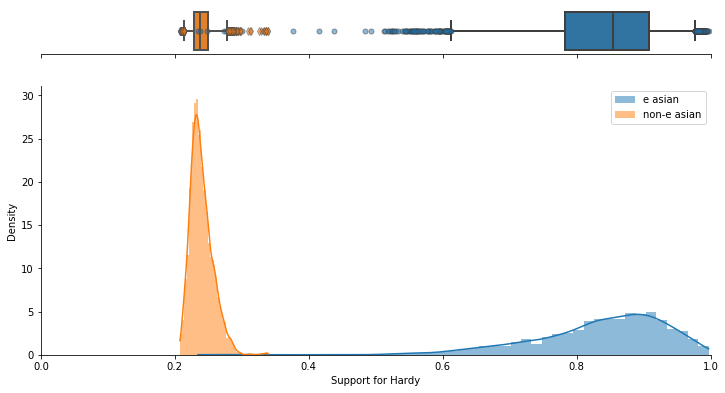

In [22]:
ei.plot();

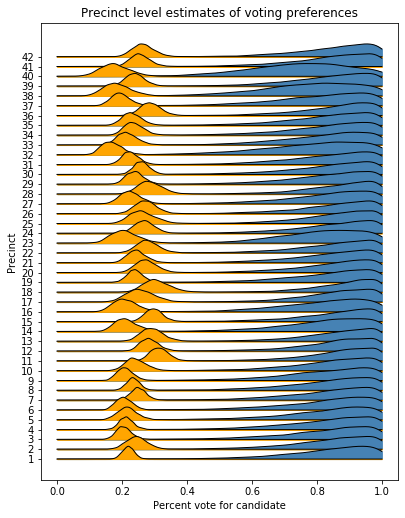

In [23]:
ei.precinct_level_plot()

## Fitting the model(s) from Wakefield 2004

Here, with beta priors

In [24]:
ei = TwoByTwoEI(model_name="wakefield_beta")
ei.fit(X, T, N, demographic_group_name=demographic_group_name, candidate_name=candidate_name, precinct_names=precinct_names)
print(ei.summary())

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b_2, b_1, kappa_2, phi_2, kappa_1, phi_1]


Sampling 4 chains for 1_500 tune and 1_000 draw iterations (6_000 + 4_000 draws total) took 639 seconds.
There were 14 divergences after tuning. Increase `target_accept` or reparameterize.


Model: wakefield_beta
        Computed from the raw b_i samples by multiplying by population and then getting
        the proportion of the total pop (total pop=summed across all districts):
        The posterior mean for the district-level voting preference of
        e_asian for Hardy is
        0.794
        The posterior mean for the district-level voting preference of
        non-e_asian for Hardy is
        0.250
        95% Bayesian credible interval for district-level voting preference of
        e_asian for Hardy is
        [0.59692468 0.92776425]
        95% Bayesian credible interval for district-level voting preference of
        non-e_asian for Hardy is
        [0.22633848 0.28132326]
        


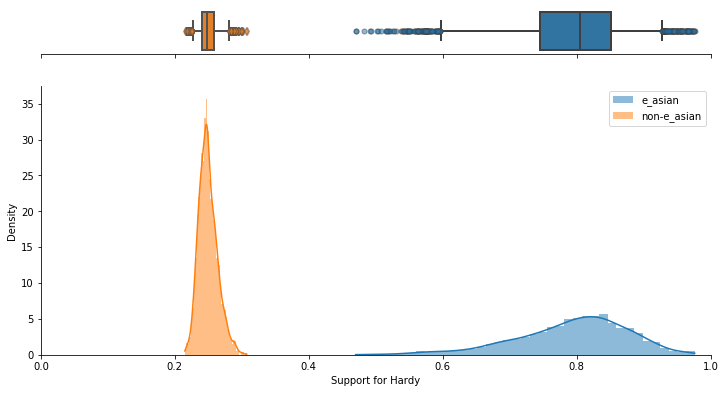

In [25]:
ei.plot();

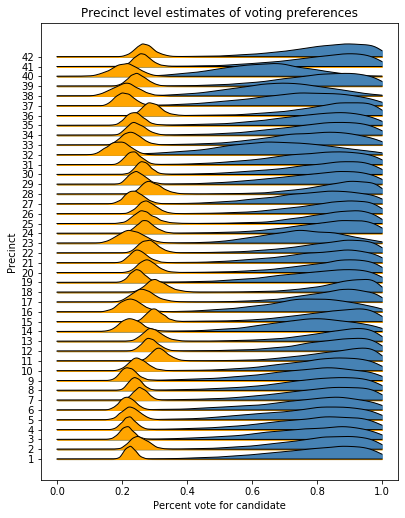

In [26]:
ei.precinct_level_plot()

In [27]:
# UNDER DEVELOPMENT
ei = TwoByTwoEI(model_name="wakefield_normal", mu0=0, mu1=0)
ei.fit(X, T, N, demographic_group_name=demographic_group_name, candidate_name=candidate_name, precinct_names=precinct_names)
print(ei.summary())

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta1, theta0, sigma1, sigma0]


Sampling 2 chains for 1_500 tune and 312 draw iterations (3_000 + 624 draws total) took 2680 seconds.


Model: wakefield_normal
        Computed from the raw b_i samples by multiplying by population and then getting
        the proportion of the total pop (total pop=summed across all districts):
        The posterior mean for the district-level voting preference of
        e_asian for Hardy is
        0.472
        The posterior mean for the district-level voting preference of
        non-e_asian for Hardy is
        0.307
        95% Bayesian credible interval for district-level voting preference of
        e_asian for Hardy is
        [0.32121386 0.52868545]
        95% Bayesian credible interval for district-level voting preference of
        non-e_asian for Hardy is
        [0.29433802 0.3342842 ]
        


[autoreload of pyei.goodmans_er failed: Traceback (most recent call last):
  File "/Users/kknuds01/miniconda3/envs/science/lib/python3.8/site-packages/IPython/extensions/autoreload.py", line 245, in check
    superreload(m, reload, self.old_objects)
  File "/Users/kknuds01/miniconda3/envs/science/lib/python3.8/site-packages/IPython/extensions/autoreload.py", line 394, in superreload
    module = reload(module)
  File "/Users/kknuds01/miniconda3/envs/science/lib/python3.8/imp.py", line 314, in reload
    return importlib.reload(module)
  File "/Users/kknuds01/miniconda3/envs/science/lib/python3.8/importlib/__init__.py", line 169, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 604, in _exec
  File "<frozen importlib._bootstrap_external>", line 783, in exec_module
  File "<frozen importlib._bootstrap>", line 219, in _call_with_frames_removed
  File "/Users/kknuds01/Documents/voting/ecological-inference/pyei/goodmans_er.py", line 104, in <module>


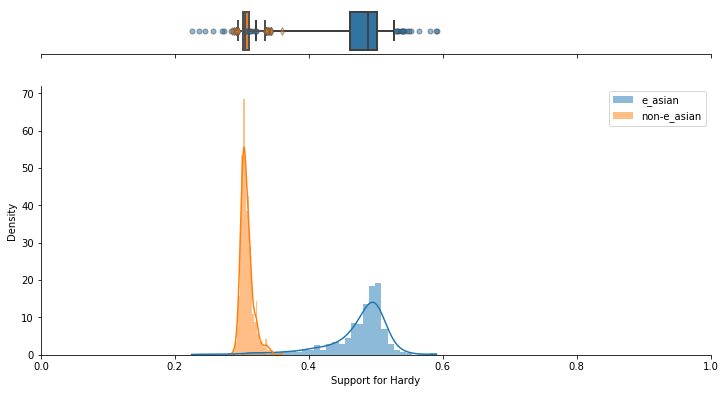

In [28]:
ei.plot();

## Fitting Goodman's ecological regression

In [13]:
goodmans_er = GoodmansER().fit(
    X, T, demographic_group_name="e asian", candidate_name="Hardy"
)
print(goodmans_er.summary())

Goodmans ER
        Est. fraction of e asian
        voters who voted for Hardy is
        0.862
        Est. fraction of non- e asian
        voters who voted for Hardy is
        0.239
        


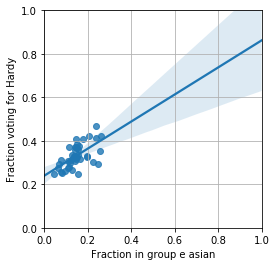

In [14]:
goodmans_er.plot();

## Fitting a weighted version of Goodman's ecological regression

In [15]:
goodmans_er = GoodmansER(is_weighted_regression="True")
goodmans_er.fit(X, T, N, demographic_group_name="e asian", candidate_name="Hardy")
print(goodmans_er.summary())

Goodmans ER, weighted by population
        Est. fraction of e asian
        voters who voted for Hardy is
        0.865
        Est. fraction of non- e asian
        voters who voted for Hardy is
        0.236
        


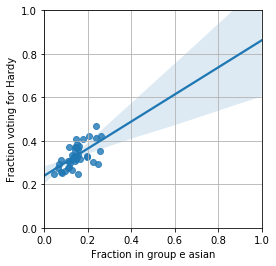

In [16]:
goodmans_er.plot();

## Fitting a Bayesian version of Goodman's ecological regression

With uniform \[0,1\] priors over the voting preferences for each group. Options to weigh the precints based on population or not.

In [8]:
bayes_goodman_ei = GoodmansERBayes("goodman_er_bayes", weighted_by_pop=True, sigma=1)
bayes_goodman_ei.fit(X, T, N, demographic_group_name=demographic_group_name, candidate_name=candidate_name)
print(bayes_goodman_ei.summary())

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [eps, b_2, b_1]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 17 seconds.


Model: goodman_er_bayes
        Computed from the raw b_i samples by multiplying by population and then getting
        the proportion of the total pop (total pop=summed across all districts):
        The posterior mean for the district-level voting preference of
        e_asian for Hardy is
        0.840
        The posterior mean for the district-level voting preference of
        non-e_asian for Hardy is
        0.240
        95% Bayesian credible interval for district-level voting preference of
        e_asian for Hardy is
        [0.63614479 0.98510761]
        95% Bayesian credible interval for district-level voting preference of
        non-e_asian for Hardy is
        [0.21107829 0.27587745]
        


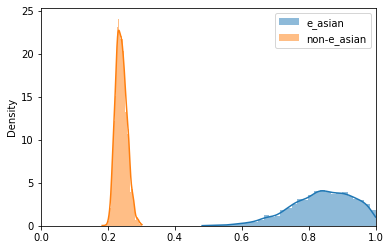

In [12]:
bayes_goodman_ei.plot_kde()

In [13]:
 x_vals, means, lower_bounds, upper_bounds = bayes_goodman_ei.compute_credible_int_for_line()

In [19]:
import arviz as az
idata = az.from_pymc3(bayes_goodman_ei.sim_trace, model=bayes_goodman_ei.sim_model)

In [20]:
idata

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> observed_data

In [23]:
idata.sample_stats.diverging

<xarray.DataArray 'diverging' (chain: 4, draw: 1000)>
array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])
Coordinates:
  * chain    (chain) int64 0 1 2 3
  * draw     (draw) int64 0 1 2 3 4 5 6 7 8 ... 992 993 994 995 996 997 998 999

In [24]:
az.stats.rhat(idata)

<xarray.Dataset>
Dimensions:  ()
Data variables:
    b_1      float64 1.002
    b_2      float64 1.002
    eps      float64 1.002